# Model Training and evaluation

In this notebook, we are going to train six models: three for linear/quadratic methods and three for non-linear methods.

In [36]:
# Uncomment to upgrade packages
# !pip3 install pandas --upgrade --quiet
# !pip3 install numpy --upgrade --quiet
# !pip3 install scipy  --upgrade --quiet
# !pip3 install statsmodels  --upgrade --quietq
# !pip3 install seaborn  --upgrade --quiet
# !pip3 install matplotlib  --upgrade --quiet
# !pip3 install scikit-learn  --upgrade 
# !pip install scikit-optimize  --quiet
!pip install apafib --upgrade  --quiet
!pip install pmlb --upgrade  --quiet

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

## Linear/Quadratic Methods

In [38]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [39]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

In [40]:
import pandas as pd
import os

files = {
    "X_train": "X_train.csv",
    "y_train": "y_train.csv",
    "X_test": "X_test.csv",
    "y_test": "y_test.csv",
}

data = {}

for key, filename in files.items():
    filepath = os.path.join('data/', filename)
    try:
        data[key] = pd.read_csv(filepath)
        print(f"{key} loaded successfully. Shape: {data[key].shape}")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{filepath}' is empty.")
    except Exception as e:
        print(f"Error loading '{filepath}': {e}")

X_train = data.get("X_train")
y_train = data.get("y_train")
X_test = data.get("X_test")
y_test = data.get("y_test")

if any(df is None for df in [X_train, y_train, X_test, y_test]):
    print("Some files could not be loaded. Please check the errors above.")
else:
    print("All files loaded successfully.")

X_train loaded successfully. Shape: (7000, 26)
y_train loaded successfully. Shape: (7000, 1)
X_test loaded successfully. Shape: (3000, 26)
y_test loaded successfully. Shape: (3000, 1)
All files loaded successfully.


In [41]:
target_names = [str(v) for v in sorted(y_train['IncidentGrade'].unique())]

### Naïve Bayes
[EXPLICATION OF WHY NAIVE BAYES]

In [42]:
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train,y_train,cv=10))
print(gnb.best_score_)

0.42614285714285716


In [43]:
gnb_model = GaussianNB().fit(X_train, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X_train.columns
means

Priors: [0.42257143 0.21757143 0.35985714]
Means:



,Timestamp,AlertTitle,Category,EntityType,EvidenceRole,Sha256,IpAddress,Url,AccountSid,AccountObjectId,...,ApplicationName,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage
0,0.515,0.031,0.484,0.591,0.500,0.884,0.856,0.902,0.831,0.833,...,0.981,0.850,0.856,0.999,0.973,0.973,0.996,0.996,0.996,0.688
1,0.453,0.027,0.495,0.519,0.518,0.942,0.813,0.960,0.844,0.854,...,0.973,0.922,0.941,1.000,0.981,0.981,0.950,0.960,0.960,0.732
2,0.472,0.003,0.558,0.532,0.645,0.971,0.728,0.949,0.724,0.724,...,0.981,0.962,0.967,1.000,0.990,0.990,0.811,0.841,0.839,0.700


In [44]:
print(classification_report(y_test, gnb_model.predict(X_test), target_names=target_names))
results_df = save_results(gnb_model, X_test, y_test, 'GNB', results_df)

                precision    recall  f1-score   support

BenignPositive       0.42      1.00      0.59      1268
 FalsePositive       0.00      0.00      0.00       653
  TruePositive       0.00      0.00      0.00      1079

      accuracy                           0.42      3000
     macro avg       0.14      0.33      0.20      3000
  weighted avg       0.18      0.42      0.25      3000



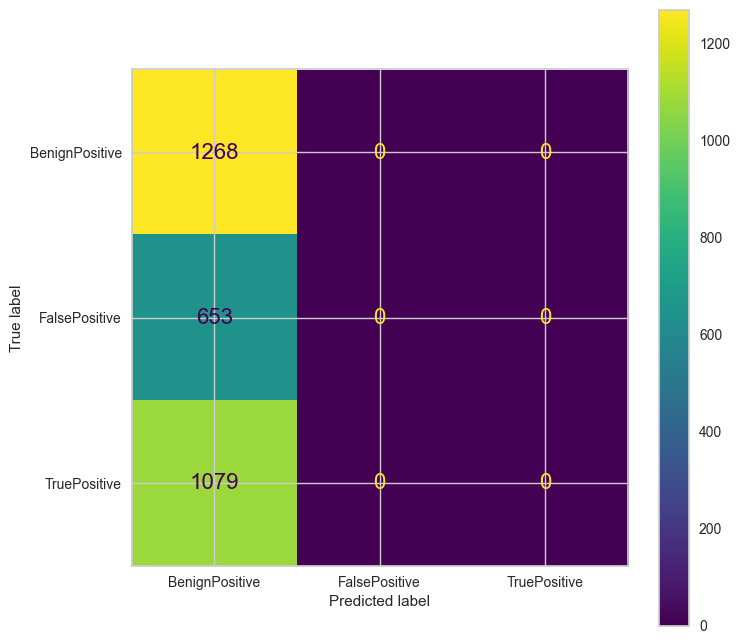

In [45]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, display_labels=target_names, ax=plt.subplot());

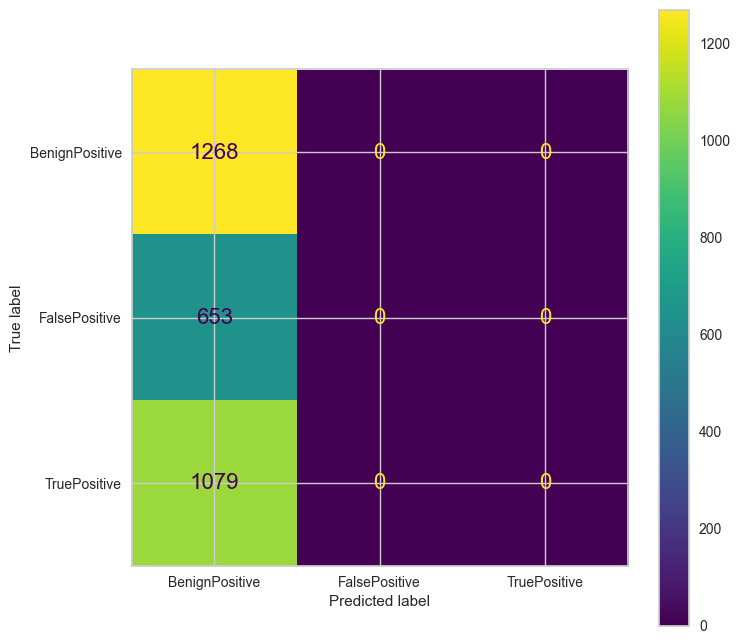

In [46]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test,y_test, display_labels=target_names, ax=plt.subplot());

### Logistic Regression
[EXPLICATION OF WHY LOGISTIC REGRESSION]

In [47]:
lr= LogisticRegression(max_iter=10000)
param = {'penalty':['l1', 'l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train, y_train.values.ravel()); # need to convert vector of column to array of 1d

In [48]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
15,"{'C': 0.12589254117941676, 'penalty': 'l2'}",0.596,1
41,"{'C': 1000.0, 'penalty': 'l2'}",0.596,2
19,"{'C': 0.501187233627272, 'penalty': 'l2'}",0.596,3
27,"{'C': 7.943282347242814, 'penalty': 'l2'}",0.596,4
37,"{'C': 251.18864315095772, 'penalty': 'l2'}",0.596,4


Coefs:


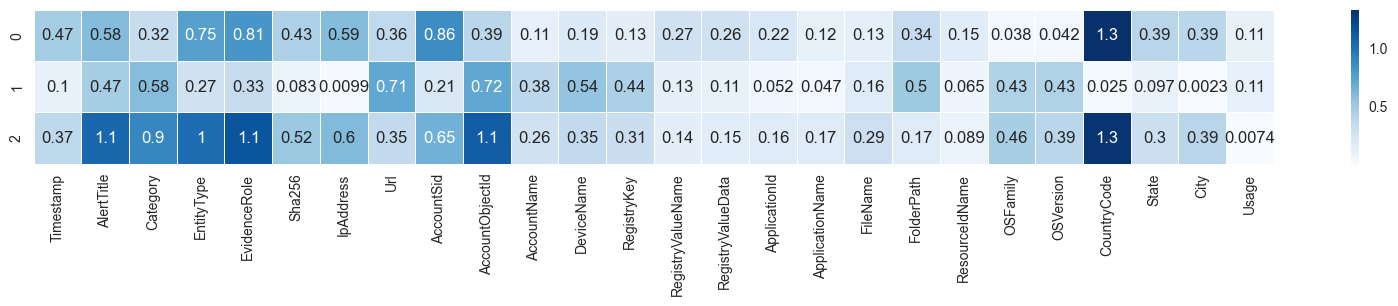

In [50]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns

plt.figure(figsize=(20,2));
sns.heatmap(coefs.abs(),annot=True, linewidths=.5,cbar=True,xticklabels=True, cmap='Blues', annot_kws={'size':12});

In [51]:
print(classification_report(y_test, lr_gs.predict(X_test), target_names=target_names))
results_df = save_results(lr_gs, X_test, y_test, 'Logistic', results_df)

                precision    recall  f1-score   support

BenignPositive       0.58      0.85      0.69      1268
 FalsePositive       0.78      0.08      0.15       653
  TruePositive       0.66      0.65      0.66      1079

      accuracy                           0.61      3000
     macro avg       0.67      0.53      0.50      3000
  weighted avg       0.65      0.61      0.56      3000



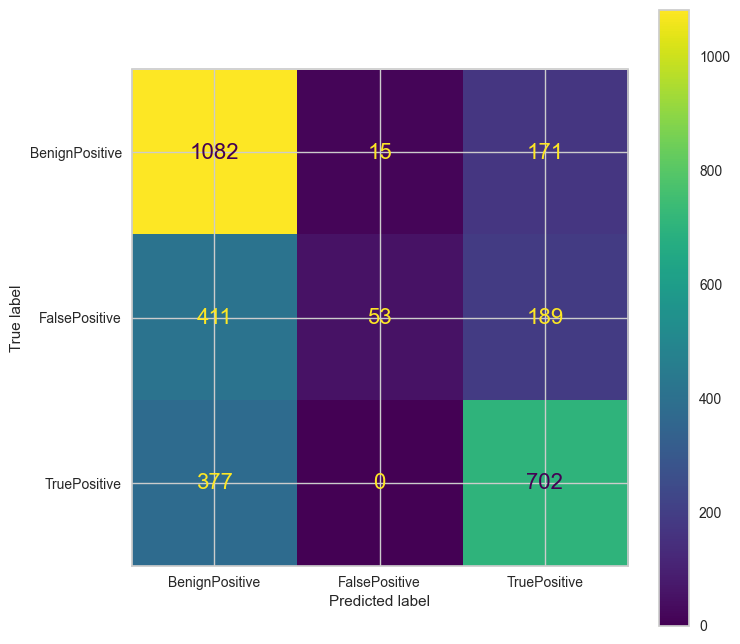

In [52]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,y_test, display_labels=target_names, ax=plt.subplot());

### K-nearest neighbours

[EXPLICATION OF WHY K-nearest neighbours]

In [55]:
scaler = MinMaxScaler()

X_train_s = X_train
X_test_s = X_test

In [58]:
knn =  KNeighborsClassifier()
param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 17, 19, 21], 
          'weights':['distance', 'uniform'], 
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs.fit(X_train_s, y_train.values.ravel());

In [59]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
34,"{'metric': 'l1', 'n_neighbors': 21, 'weights': 'distance'}",0.662,1
32,"{'metric': 'l1', 'n_neighbors': 19, 'weights': 'distance'}",0.662,2
30,"{'metric': 'l1', 'n_neighbors': 17, 'weights': 'distance'}",0.659,3
28,"{'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.658,4
14,"{'metric': 'l2', 'n_neighbors': 19, 'weights': 'distance'}",0.656,5


In [60]:
print(classification_report(y_test, knn_gs.predict(X_test_s), target_names=target_names))
results_df = save_results(knn_gs, X_test_s, y_test, 'KNN', results_df)

                precision    recall  f1-score   support

BenignPositive       0.63      0.81      0.71      1268
 FalsePositive       0.55      0.31      0.39       653
  TruePositive       0.73      0.68      0.70      1079

      accuracy                           0.65      3000
     macro avg       0.64      0.60      0.60      3000
  weighted avg       0.65      0.65      0.64      3000



Podemos ver también cierto desbalance en sus predicciones

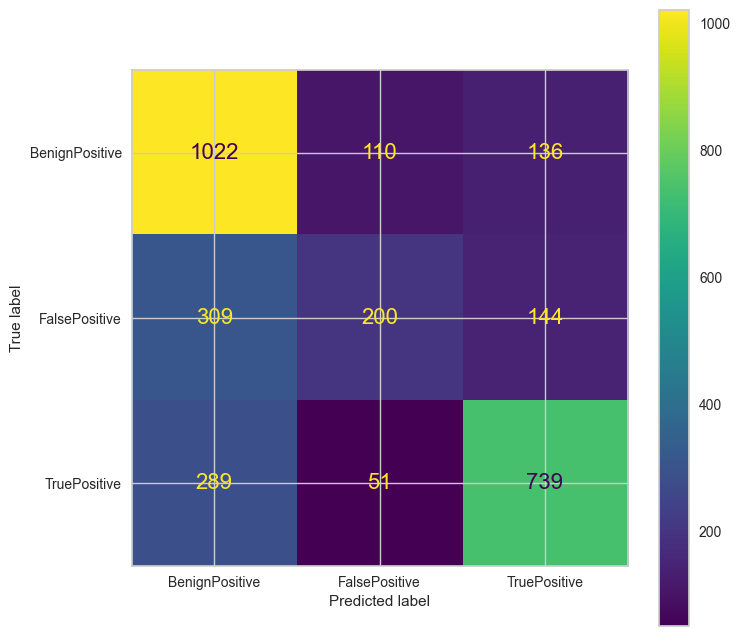

In [61]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_s,y_test, display_labels=target_names, ax=plt.subplot());

In [62]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
KNN,0.662,0.654,0.637,0.599,0.602
Logistic,0.596,0.612,0.673,0.528,0.497
GNB,NaN,0.423,0.141,0.333,0.198


## Non-Linear Methods

### Random forest

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, StackingClassifier,
                              VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, PrecisionRecallDisplay,
                             RocCurveDisplay, accuracy_score,
                             classification_report, f1_score, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc

np.int = int # fix for skopt
import warnings

import dtreeviz
from apafib import load_attrition
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [66]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
         'criterion':['gini', 'entropy'],
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}
iter = 40
rf =  RandomForestClassifier(random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=iter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train, y_train.values.ravel());

In [67]:
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
28,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}",0.711,1
38,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}",0.709,2
33,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 40}",0.708,3
29,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 50}",0.708,4
18,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}",0.707,5


In [68]:
print(classification_report(y_test, rf_bs.predict(X_test), target_names=target_names))
results_df = save_results(rf_bs, X_test, y_test, 'Random Forest', results_df)

                precision    recall  f1-score   support

BenignPositive       0.66      0.90      0.76      1268
 FalsePositive       0.79      0.37      0.50       653
  TruePositive       0.78      0.70      0.74      1079

      accuracy                           0.71      3000
     macro avg       0.75      0.66      0.67      3000
  weighted avg       0.73      0.71      0.70      3000



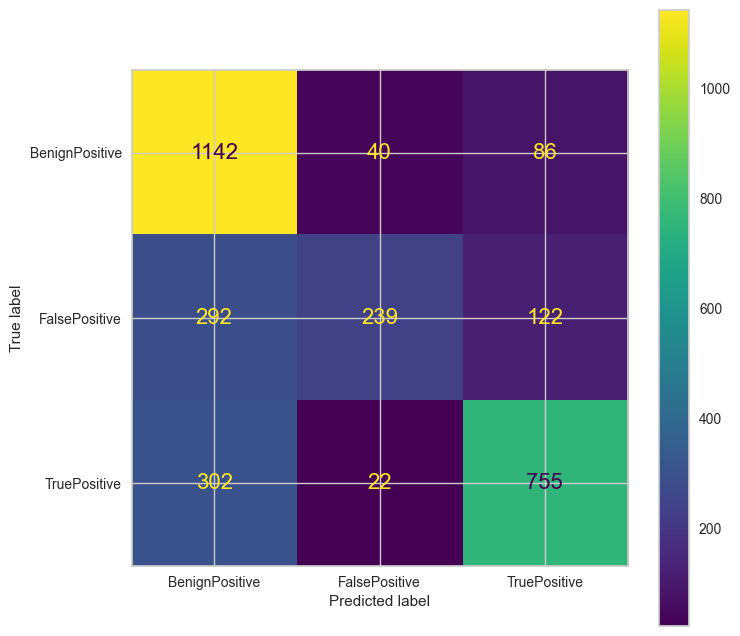

In [69]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rf_bs, X_test,y_test, ax=plt.subplot());

### Gradient Boosting